# An√°lise Explorat√≥ria e Teste de Hip√≥tese (Google Colab)

---

# An√°lise Explorat√≥ria de Dados e Teste de Hip√≥tese  
**Google Colab Notebook**

---

## 1. Introdu√ß√£o

Este notebook apresenta uma **an√°lise explorat√≥ria** do seu dataset de partidas e operadores, seguida de um **teste de hip√≥tese por permuta√ß√£o** que verifica se jogadores de um determinado *skill rank* t√™m prefer√™ncia por certos operadores.



---

## 2. Configura√ß√£o do Ambiente

In [ ]:
# Importa√ß√£o das bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo dos gr√°ficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/TP icd'

analiseexp_operator.ipynb  final_dataset.parquet  r6concat.ipynb



---

## 3. Carregamento dos Dados

In [ ]:
# Ajuste o caminho para o seu arquivo Parquet no Colab
df = pd.read_parquet("/content/drive/MyDrive/TP icd/final_dataset.parquet")
#dataset tem 84 milhoes de linhas

# 3.2 Amostragem estratificada por skillrank
#      Selecionamos cada skillrank, mantendo propor√ß√µes aproximadas
frac = 0.07
df_sample = (
    df
    .groupby("skillrank", group_keys=False)
    .apply(lambda x: x.sample(frac=frac, random_state=42))
)
print(f"Amostra estratificada: {df_sample.shape[0]:,} linhas (~{frac*100:.2f}% de cada rank)")

# 3.3 Usaremos df_sample para toda a an√°lise adiante
df = df_sample.copy()


<ipython-input-10-463387ab0389>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=frac, random_state=42))


Amostra estratificada: 5,921,182 linhas (~7.00% de cada rank)



---

## 4. Vis√£o Geral do Dataset

In [ ]:
# Tipos e valores ausentes
df.info()

# Estat√≠sticas descritivas (num√©ricas)
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5921182 entries, 76125 to 9866
Data columns (total 19 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   dateid             int64 
 1   platform           object
 2   gamemode           object
 3   mapname            object
 4   matchid            int64 
 5   roundnumber        int64 
 6   objectivelocation  object
 7   winrole            object
 8   endroundreason     object
 9   roundduration      int64 
 10  clearancelevel     int64 
 11  skillrank          object
 12  role               object
 13  team               int64 
 14  haswon             int64 
 15  operator           object
 16  nbkills            int64 
 17  isdead             int64 
 18  SPECIALTY          object
dtypes: int64(9), object(10)
memory usage: 903.5+ MB


dateid       matchid   roundnumber  roundduration  \
count  5.921182e+06  5.921182e+06  5.921182e+06   5.921182e+06   
mean   2.017035e+07  2.147366e+09  3.609712e+00   1.849437e+02   
std    9.662830e+01  1.239381e+09  2.040313e+00   4.512320e+01   
min    2.017021e+07  9.701000e+03  1.000000e+00   6.000000e+00   
25%    2.017030e+07  1.074076e+09  2.000000e+00   1.540000e+02   
50%    2.017033e+07  2.148183e+09  3.000000e+00   1.870000e+02   
75%    2.017042e+07  3.218524e+09  5.000000e+00   2.220000e+02   
max    2.017052e+07  4.294966e+09  9.000000e+00   1.276900e+04   

       clearancelevel          team        haswon       nbkills        isdead  
count    5.921182e+06  5.921182e+06  5.921182e+06  5.921182e+06  5.921182e+06  
mean     9.616105e+01  4.997619e-01  5.093456e-01  7.038176e-01  7.046917e-01  
std      4.702593e+01  5.000000e-01  4.999127e-01  9.255180e-01  4.561812e-01  
min      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
25%      6.200000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
50%      9.200000e+01  0.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00  
75%      1.260000e+02  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
max      5.840000e+02  1.000000e+00  1.000000e+00  8.000000e+00  1.000000e+00

---

## 5. An√°lise Explorat√≥ria (Visualiza√ß√µes)

5.1. Operador por Skill Rank

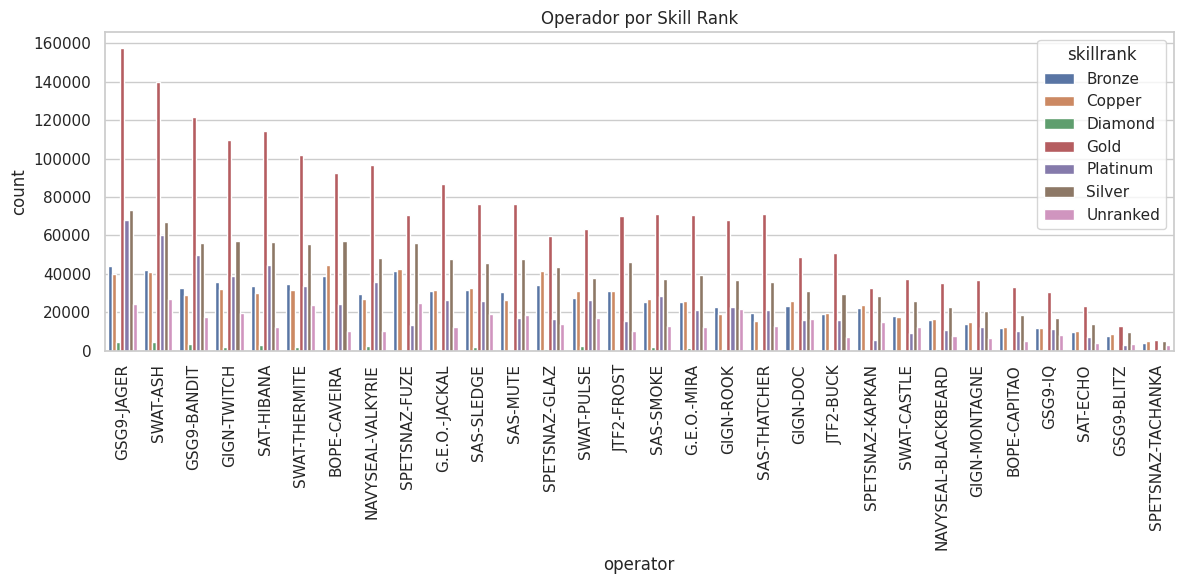

In [ ]:
plt.figure()
sns.countplot(
    data=df,
    x="operator",
    hue="skillrank",
    order=df["operator"].value_counts().index
)
plt.title("Operador por Skill Rank")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


5.2. Operador por Mapa

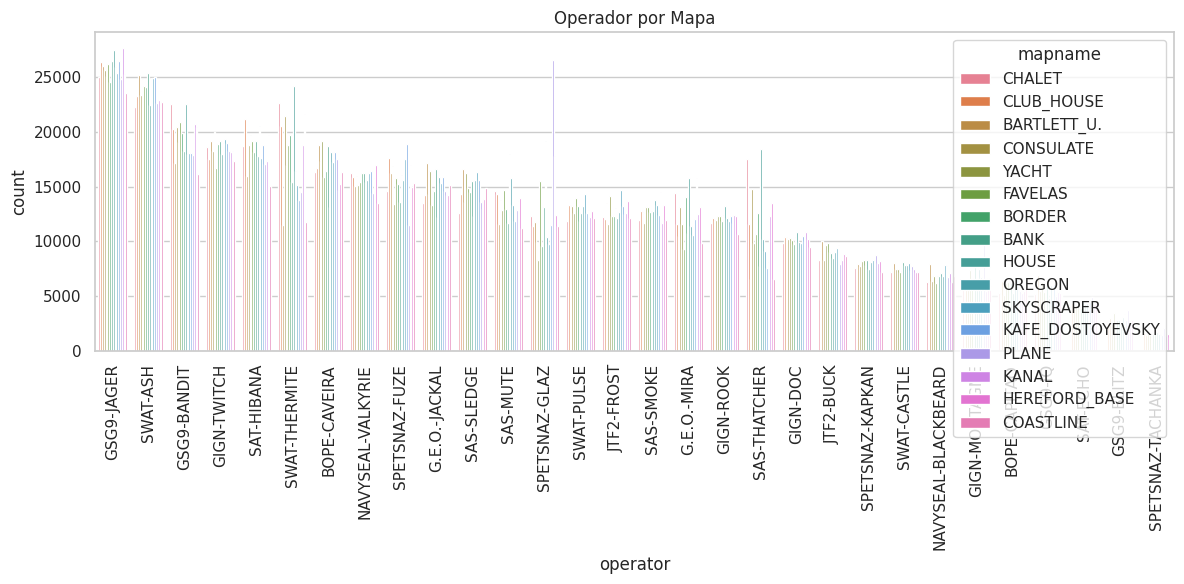

In [ ]:
plt.figure()
sns.countplot(
    data=df,
    x="operator",
    hue="mapname",
    order=df["operator"].value_counts().index
)
plt.title("Operador por Mapa")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

5.3. Vit√≥rias vs Escolhas (Picks vs Victories)

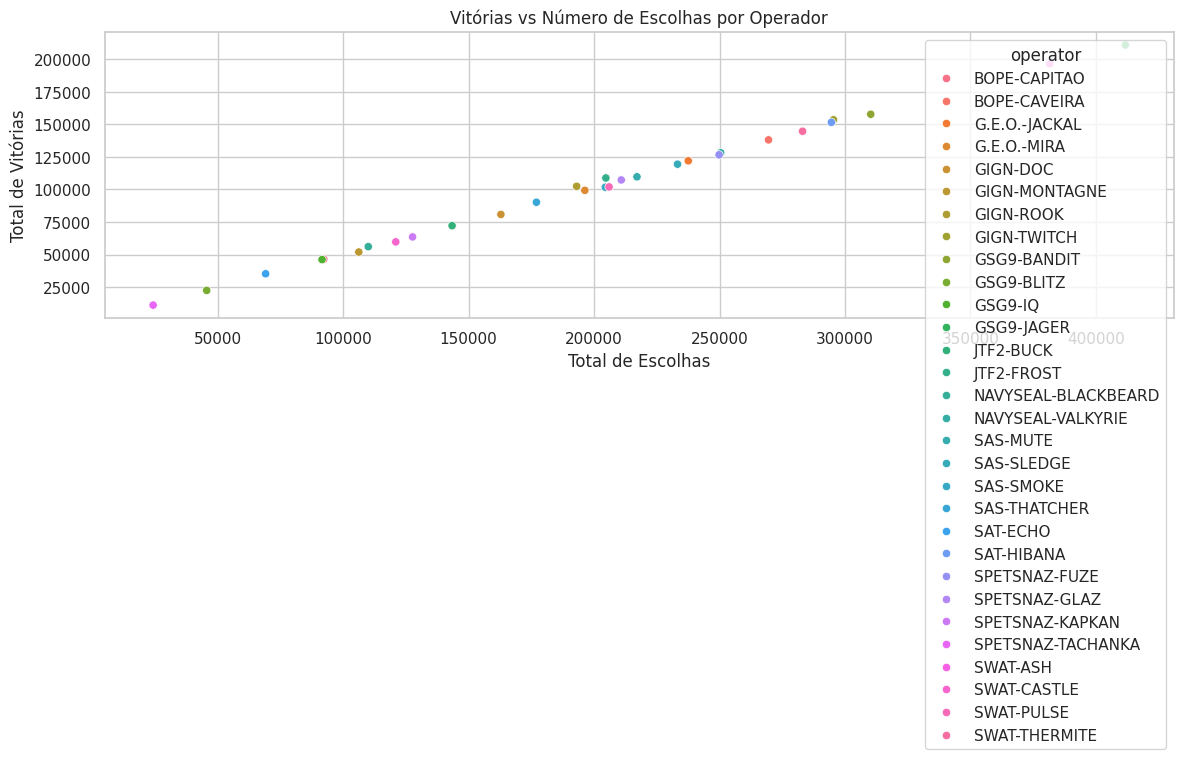

In [ ]:
op_stats = (
    df.groupby("operator")
      .agg(victories=("haswon", "sum"), picks=("operator", "count"))
      .reset_index()
)

plt.figure()
sns.scatterplot(
    data=op_stats,
    x="picks",
    y="victories",
    hue="operator",
    legend=True
)
plt.title("Vit√≥rias vs N√∫mero de Escolhas por Operador")
plt.xlabel("Total de Escolhas")
plt.ylabel("Total de Vit√≥rias")
plt.tight_layout()
plt.show()

5.4. Especialidades por Mapa

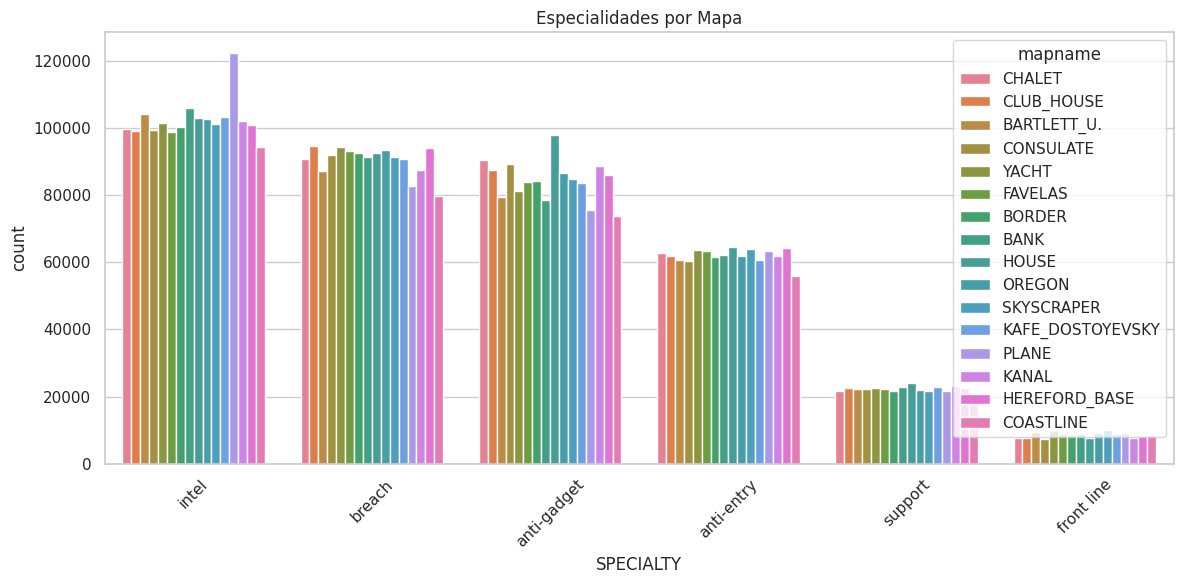

In [ ]:
plt.figure()
sns.countplot(
    data=df,
    x="SPECIALTY",
    hue="mapname",
    order=df["SPECIALTY"].value_counts().index
)
plt.title("Especialidades por Mapa")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5.5. Operadores que Mais Morrem

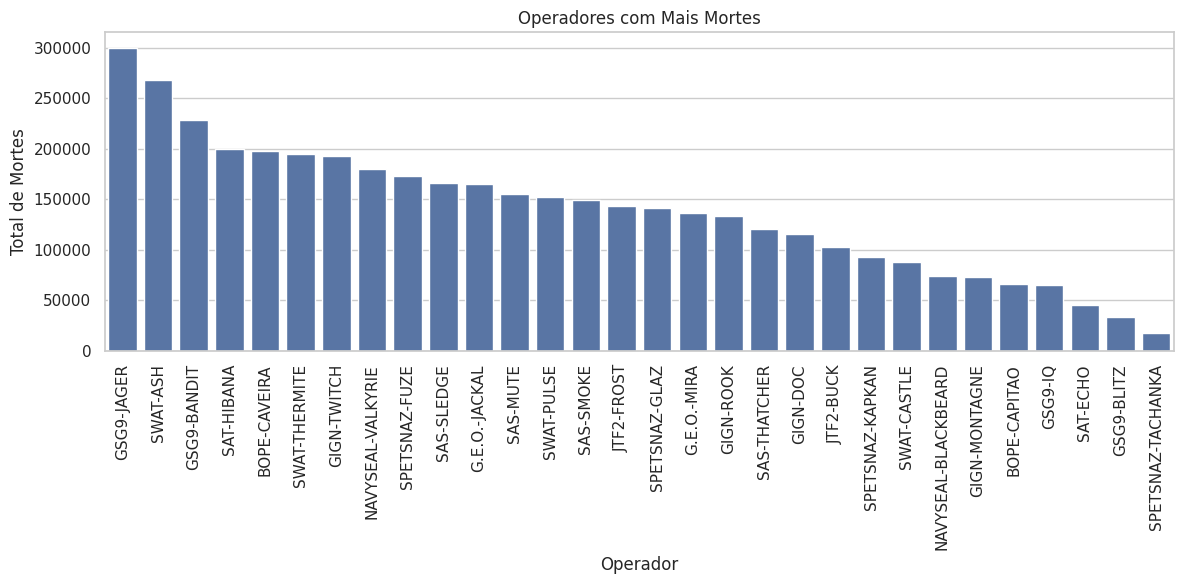

In [ ]:
dead_counts = df[df["isdead"] == True]["operator"].value_counts()

plt.figure()
sns.barplot(x=dead_counts.index, y=dead_counts.values)
plt.title("Operadores com Mais Mortes")
plt.xlabel("Operador")
plt.ylabel("Total de Mortes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


5.6. Kills por Operador

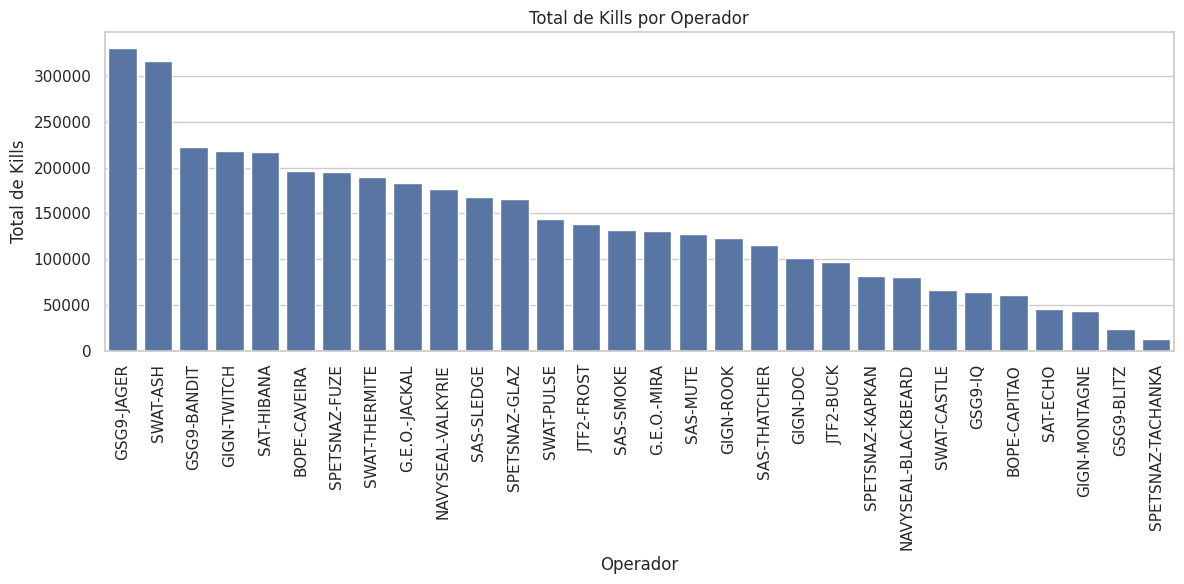

In [ ]:
kills_tot = df.groupby("operator")["nbkills"].sum().sort_values(ascending=False)

plt.figure()
sns.barplot(x=kills_tot.index, y=kills_tot.values)
plt.title("Total de Kills por Operador")
plt.xlabel("Operador")
plt.ylabel("Total de Kills")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

6.Teste de Hip√≥tese por Permuta√ß√£o

6.1. Prefer√™ncia de Operadores por Skill Rank
Hip√≥tese

ùêª
0: A propor√ß√£o de escolhas de certos operadores √© igual para jogadores de um skill rank
ùëÖ
R e para os demais.

ùêª
ùê¥‚Äã: H√° diferen√ßa na propor√ß√£o de escolhas.

Prop. em Platinum: 0.184
Prop. fora de Platinum: 0.127
Diferen√ßa observada: 0.057
P-valor (permuta√ß√µes): 0.0000


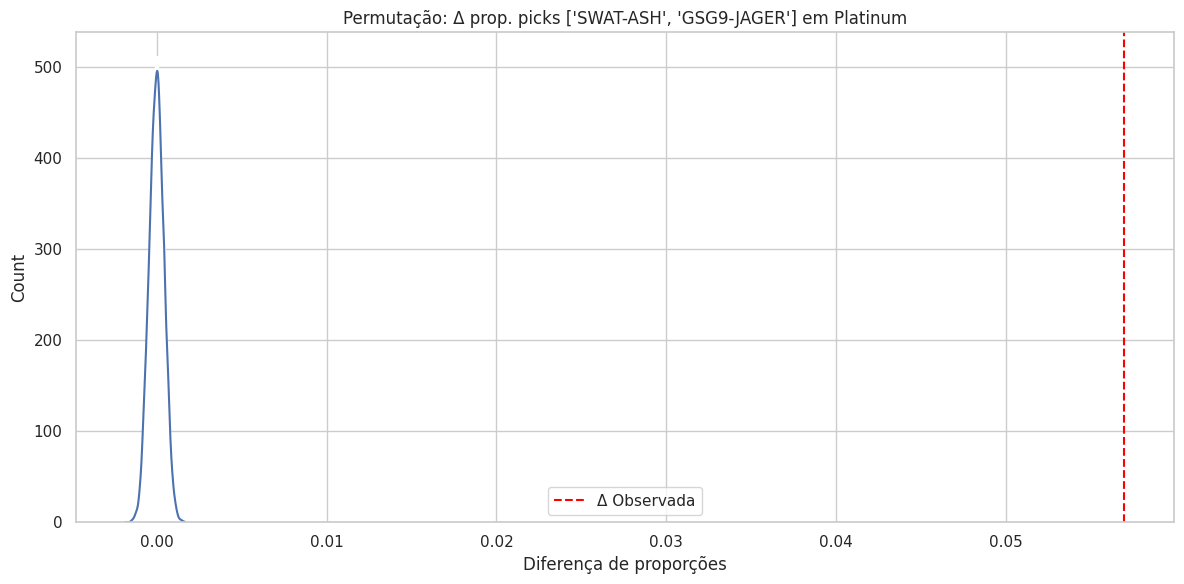

In [ ]:
# 6.1.1 Par√¢metros de interesse
skillrank_interest = "Platinum"            # pode alterar
operators_interest  = ["SWAT-ASH", "GSG9-JAGER"] # pode alterar

# 6.1.2 Marca quem pertence ao rank de interesse
df["is_interest"] = df["skillrank"] == skillrank_interest

# 6.1.3 Propor√ß√µes observadas
p_in   = df.loc[df["is_interest"], "operator"].isin(operators_interest).mean()
p_out  = df.loc[~df["is_interest"], "operator"].isin(operators_interest).mean()
obs_diff = p_in - p_out

print(f"Prop. em {skillrank_interest}: {p_in:.3f}")
print(f"Prop. fora de {skillrank_interest}: {p_out:.3f}")
print(f"Diferen√ßa observada: {obs_diff:.3f}")

# 6.1.4 Fun√ß√£o de permuta√ß√£o
def perm_pref_test(flags, picks, n_perm=10000):
    diffs = np.empty(n_perm)
    for i in range(n_perm):
        np.random.shuffle(flags)
        diffs[i] = picks[flags].mean() - picks[~flags].mean()
    p_value = np.mean(np.abs(diffs) >= abs(obs_diff))
    return diffs, p_value

# 6.1.5 Executa o teste
flags_arr = df["is_interest"].values
picks_arr = df["operator"].isin(operators_interest).values
perm_diffs, p_val = perm_pref_test(flags_arr, picks_arr, n_perm=10000)

print(f"P-valor (permuta√ß√µes): {p_val:.4f}")

# 6.1.6 Visualiza√ß√£o da distribui√ß√£o nula
plt.figure()
sns.histplot(perm_diffs, kde=True)
plt.axvline(obs_diff, color="red", linestyle="--", label="Œî Observada")
plt.title(f"Permuta√ß√£o: Œî prop. picks {operators_interest} em {skillrank_interest}")
plt.xlabel("Diferen√ßa de propor√ß√µes")
plt.legend()
plt.tight_layout()
plt.show()
